# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

In [3]:
FacesData = np.vstack(tup=(BahramFace['Intensification_Data'], 
                       DJFace['Intensification_Data'], 
                       NickFace['Intensification_Data'],
                      RoohiFace['Intensification_Data'],
                      SarahFace['Intensification_Data']))

In [4]:
FacesLabel = np.vstack(tup=(BahramFace['Intensification_Label'], 
                       DJFace['Intensification_Label'], 
                       NickFace['Intensification_Label'],
                      RoohiFace['Intensification_Label'],
                      SarahFace['Intensification_Label']))

In [5]:
(FacesData.shape, FacesData.dtype, FacesLabel.shape, FacesLabel.dtype)

((18720, 205, 16), dtype('<f8'), (18720, 1), dtype('uint8'))

In [6]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [7]:
# Standardize/normalize train and test
X_norm = normalize(inputs=FacesData)

In [8]:
# Deviding the input data into train and validation
# 30 % of data is test and the rest train
length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

# Output labels and classes

In [10]:
Y_train = np.array(FacesLabel[ :-length], dtype=int).reshape(-1)
Y_valid = np.array(FacesLabel[-length: ], dtype=int).reshape(-1)

In [11]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype)

((13104, 205, 16), dtype('<f8'), (13104,), dtype('int64'))

### Hyperparameters

In [33]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train.max() + 1

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [34]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)

In [35]:
(Y_train_onehot.shape, Y_valid_onehot.shape, X_train_norm.shape, X_valid_norm.shape)

((13104, 2), (5616, 2), (13104, 205, 16), (5616, 205, 16))

# GPUs or CPU

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [37]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [38]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap and 60% overlapping window
out_conv = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=5, strides=2, padding='valid', 
                            activation = tf.nn.relu)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 101*32) --> (batch, 101*32*2)
# 101*32 = 202 + 3030 = 3232*2 = 6464
in_fc = tf.reshape(out_conv, (-1, 101*32))
out_fc = tf.layers.dense(inputs=in_fc, units=101*32*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 101*32*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 3232) (?, 6464)
(?, 2)


In [39]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [40]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

Epoch: 1/5 Train loss: 0.829839 Valid loss: 8.874117 train acc: 0.389313 Valid acc: 0.833333
Epoch: 1/5 Train loss: 5.771125 Valid loss: 8.729640 train acc: 0.832061 Valid acc: 0.833333
Epoch: 1/5 Train loss: 5.526344 Valid loss: 6.158086 train acc: 0.832061 Valid acc: 0.833333
Epoch: 1/5 Train loss: 3.999226 Valid loss: 3.466764 train acc: 0.832061 Valid acc: 0.833333
Epoch: 1/5 Train loss: 2.339429 Valid loss: 1.574927 train acc: 0.832061 Valid acc: 0.833333
Epoch: 1/5 Train loss: 1.019808 Valid loss: 0.638884 train acc: 0.847328 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.523283 Valid loss: 0.501498 train acc: 0.824427 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.435623 Valid loss: 0.617362 train acc: 0.832061 Valid acc: 0.844373
Epoch: 1/5 Train loss: 0.550807 Valid loss: 0.667551 train acc: 0.832061 Valid acc: 0.744836
Epoch: 1/5 Train loss: 0.621794 Valid loss: 0.665792 train acc: 0.877863 Valid acc: 0.801282
Epoch: 1/5 Train loss: 0.637697 Valid loss: 0.645365 train acc: 0.8473

Epoch: 1/5 Train loss: 0.545155 Valid loss: 0.492756 train acc: 0.755725 Valid acc: 0.851318
Epoch: 1/5 Train loss: 0.543842 Valid loss: 0.492365 train acc: 0.748092 Valid acc: 0.850427
Epoch: 1/5 Train loss: 0.539591 Valid loss: 0.491514 train acc: 0.778626 Valid acc: 0.850071
Epoch: 1/5 Train loss: 0.375679 Valid loss: 0.493259 train acc: 0.854962 Valid acc: 0.848825
Epoch: 1/5 Train loss: 0.384842 Valid loss: 0.498763 train acc: 0.862595 Valid acc: 0.845976
Epoch: 1/5 Train loss: 0.433501 Valid loss: 0.501895 train acc: 0.862595 Valid acc: 0.845441
Epoch: 1/5 Train loss: 0.336882 Valid loss: 0.504410 train acc: 0.870229 Valid acc: 0.843839
Epoch: 1/5 Train loss: 0.406669 Valid loss: 0.504991 train acc: 0.870229 Valid acc: 0.842949
Epoch: 1/5 Train loss: 0.367899 Valid loss: 0.509951 train acc: 0.847328 Valid acc: 0.842236
Epoch: 1/5 Train loss: 0.343936 Valid loss: 0.516859 train acc: 0.839695 Valid acc: 0.841702
Epoch: 1/5 Train loss: 0.337838 Valid loss: 0.524445 train acc: 0.8549

Epoch: 2/5 Train loss: 0.287306 Valid loss: 0.672636 train acc: 0.877863 Valid acc: 0.840990
Epoch: 2/5 Train loss: 0.312429 Valid loss: 0.688732 train acc: 0.847328 Valid acc: 0.840278
Epoch: 2/5 Train loss: 0.291529 Valid loss: 0.705133 train acc: 0.885496 Valid acc: 0.839922
Epoch: 2/5 Train loss: 0.282309 Valid loss: 0.717759 train acc: 0.870229 Valid acc: 0.840456
Epoch: 2/5 Train loss: 0.402968 Valid loss: 0.714176 train acc: 0.870229 Valid acc: 0.842949
Epoch: 2/5 Train loss: 0.279307 Valid loss: 0.708100 train acc: 0.877863 Valid acc: 0.845620
Epoch: 2/5 Train loss: 0.369090 Valid loss: 0.695239 train acc: 0.847328 Valid acc: 0.847400
Epoch: 2/5 Train loss: 0.268213 Valid loss: 0.685028 train acc: 0.877863 Valid acc: 0.849181
Epoch: 2/5 Train loss: 0.275646 Valid loss: 0.675251 train acc: 0.885496 Valid acc: 0.851496
Epoch: 2/5 Train loss: 0.349637 Valid loss: 0.667837 train acc: 0.839695 Valid acc: 0.854879
Epoch: 2/5 Train loss: 0.574167 Valid loss: 0.659089 train acc: 0.7709

Epoch: 3/5 Train loss: 0.361290 Valid loss: 0.742620 train acc: 0.854962 Valid acc: 0.851496
Epoch: 3/5 Train loss: 0.478630 Valid loss: 0.732493 train acc: 0.809160 Valid acc: 0.852208
Epoch: 3/5 Train loss: 0.345238 Valid loss: 0.725588 train acc: 0.862595 Valid acc: 0.852386
Epoch: 3/5 Train loss: 0.443272 Valid loss: 0.714706 train acc: 0.801527 Valid acc: 0.851496
Epoch: 3/5 Train loss: 0.297701 Valid loss: 0.706084 train acc: 0.862595 Valid acc: 0.851674
Epoch: 3/5 Train loss: 0.280206 Valid loss: 0.702096 train acc: 0.900763 Valid acc: 0.852208
Epoch: 3/5 Train loss: 0.329013 Valid loss: 0.704464 train acc: 0.900763 Valid acc: 0.852030
Epoch: 3/5 Train loss: 0.261616 Valid loss: 0.714383 train acc: 0.908397 Valid acc: 0.849537
Epoch: 3/5 Train loss: 0.252217 Valid loss: 0.727893 train acc: 0.916031 Valid acc: 0.849715
Epoch: 3/5 Train loss: 0.307332 Valid loss: 0.746341 train acc: 0.885496 Valid acc: 0.849003
Epoch: 3/5 Train loss: 0.263676 Valid loss: 0.767481 train acc: 0.8778

Epoch: 4/5 Train loss: 0.301844 Valid loss: 0.959929 train acc: 0.885496 Valid acc: 0.843305
Epoch: 4/5 Train loss: 0.320528 Valid loss: 0.954854 train acc: 0.870229 Valid acc: 0.842771
Epoch: 4/5 Train loss: 0.302664 Valid loss: 0.941942 train acc: 0.839695 Valid acc: 0.842592
Epoch: 4/5 Train loss: 0.284074 Valid loss: 0.926819 train acc: 0.885496 Valid acc: 0.843127
Epoch: 4/5 Train loss: 0.368288 Valid loss: 0.905089 train acc: 0.854962 Valid acc: 0.843661
Epoch: 4/5 Train loss: 0.325998 Valid loss: 0.884682 train acc: 0.893130 Valid acc: 0.844729
Epoch: 4/5 Train loss: 0.215929 Valid loss: 0.873331 train acc: 0.908397 Valid acc: 0.844373
Epoch: 4/5 Train loss: 0.313723 Valid loss: 0.864026 train acc: 0.862595 Valid acc: 0.843661
Epoch: 4/5 Train loss: 0.300541 Valid loss: 0.857524 train acc: 0.839695 Valid acc: 0.843661
Epoch: 4/5 Train loss: 0.382921 Valid loss: 0.849952 train acc: 0.854962 Valid acc: 0.844551
Epoch: 4/5 Train loss: 0.353216 Valid loss: 0.843701 train acc: 0.8473

Epoch: 5/5 Train loss: 0.108593 Valid loss: 1.108639 train acc: 0.946565 Valid acc: 0.843305
Epoch: 5/5 Train loss: 0.064468 Valid loss: 1.115670 train acc: 0.984733 Valid acc: 0.842592
Epoch: 5/5 Train loss: 0.185427 Valid loss: 1.116210 train acc: 0.938931 Valid acc: 0.842414
Epoch: 5/5 Train loss: 0.069063 Valid loss: 1.126435 train acc: 0.977099 Valid acc: 0.841702
Epoch: 5/5 Train loss: 0.168678 Valid loss: 1.116498 train acc: 0.938931 Valid acc: 0.841346
Epoch: 5/5 Train loss: 0.194311 Valid loss: 1.095913 train acc: 0.938931 Valid acc: 0.841346
Epoch: 5/5 Train loss: 0.173922 Valid loss: 1.082008 train acc: 0.931298 Valid acc: 0.840634
Epoch: 5/5 Train loss: 0.117349 Valid loss: 1.073065 train acc: 0.969466 Valid acc: 0.840278
Epoch: 5/5 Train loss: 0.166822 Valid loss: 1.070997 train acc: 0.938931 Valid acc: 0.840456
Epoch: 5/5 Train loss: 0.058127 Valid loss: 1.074133 train acc: 0.992366 Valid acc: 0.840456
Epoch: 5/5 Train loss: 0.145964 Valid loss: 1.083938 train acc: 0.9465

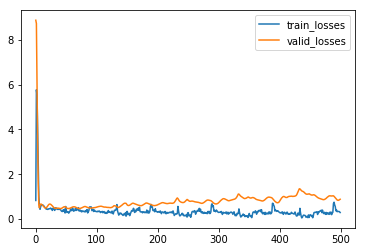

In [41]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

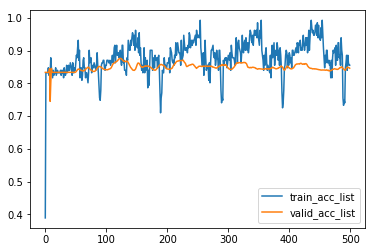

In [42]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()